# Clustering Model

### Summary: 

### Load the dataset `sentences_v1.csv`, created in the baseline mode

In [3]:
import pandas as pd 
import numpy as np

sentences_df = pd.read_csv('../datasets/sentences_v1.csv')
extended_df = pd.read_csv('../datasets/extended_df.csv')

In [4]:
sentences_df.drop(columns=['Unnamed;'])

,Unnamed: 0.1,Unnamed: 0,Sentence Length,Sentence#,Content,Tagged Words,Shortened Sentences
0,0,0,24,1,"['Thousands', 'of', 'demonstrators', 'have', '...","['London', 'Iraq', 'British']",Thousands demonstrators marched London pro...
1,1,1,30,2,"['Families', 'of', 'soldiers', 'killed', 'in',...",['Bush'],Families soldiers killed conflict joined p...
2,2,2,14,3,"['They', 'marched', 'from', 'the', 'Houses', '...","['Hyde', 'Park']",marched Houses Parliament rally Hyde Pa...
3,3,3,15,4,"['Police', 'put', 'the', 'number', 'of', 'marc...",NaN,"Police number marchers 10,000 organizers ..."
4,4,4,25,5,"['The', 'protest', 'comes', 'on', 'the', 'eve'...","['Britain', 'Labor', 'Party', 'English', 'Brig...",protest comes eve annual conference Brit...
...,...,...,...,...,...,...,...
47954,47954,47954,20,47955,"['Indian', 'border', 'security', 'forces', 'ar...","['Indian', 'Pakistani', 'Punjab']",Indian border security forces accusing Pakis...
47955,47955,47955,24,47956,"['Indian', 'officials', 'said', 'no', 'one', '...","['Indian', 'Saturday']",Indian officials said injured Saturday in...
47956,47956,47956,11,47957,"['Two', 'more', 'landed', 'in', 'fields', 'bel...",NaN,landed fields belonging nearby village .
47957,47957,47957,11,47958,"['They', 'say', 'not', 'all', 'of', 'the', 'ro...",NaN,rockets exploded impact .


## Add features to `sentences_df`

In this section, we create `sentences_df`

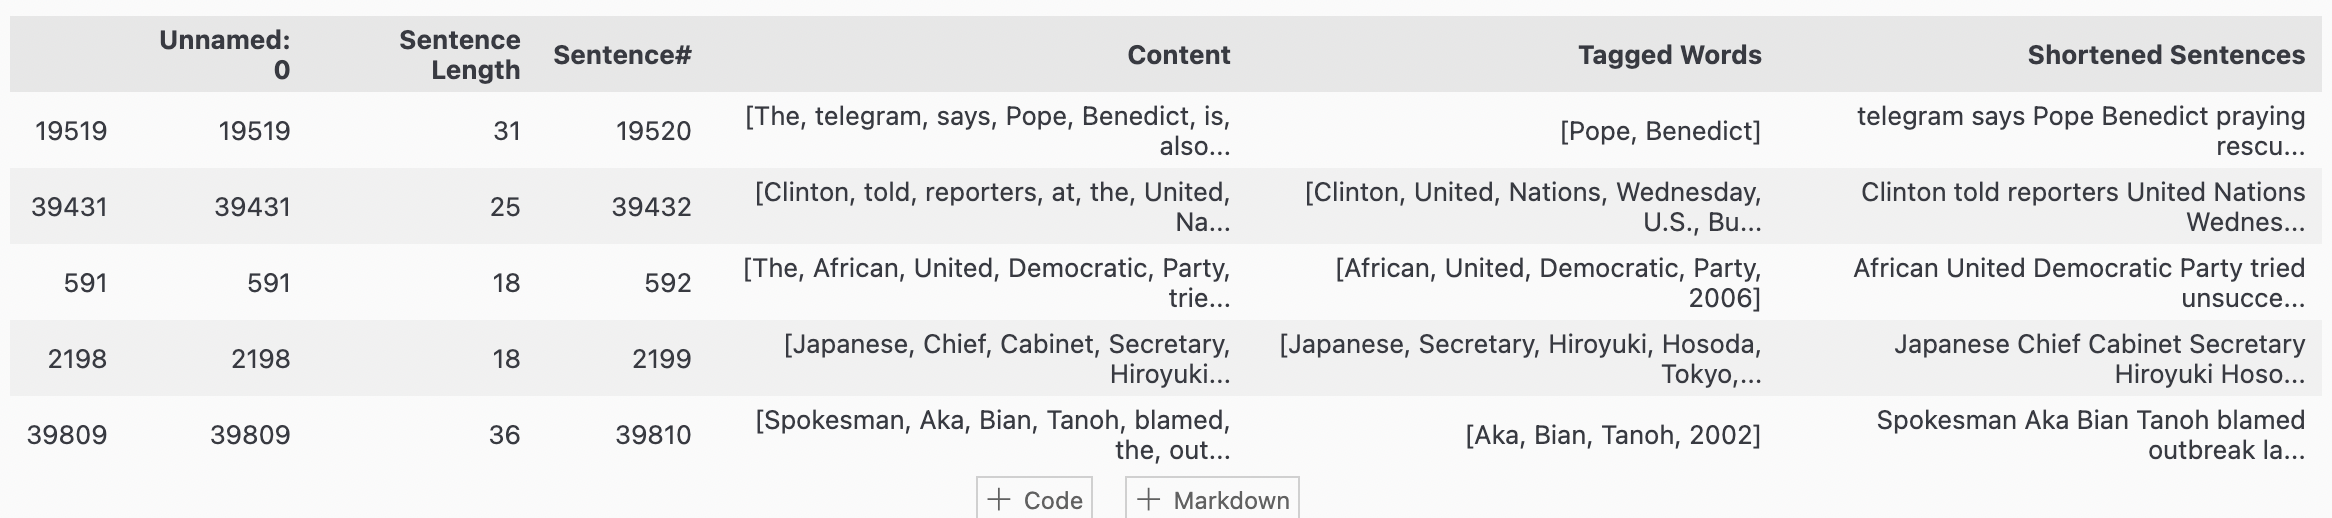

In [1]:
from IPython.display import Image, display
filename = '../doc_img/sentences_df.png'
display(Image(filename=filename))

### Prepare `reduced_df` for feature extraction of `sentences_df`

In [2]:
reduced_df = extended_df[['Sentence #', 'Word', 'Tag', 'StopWord', 'Non-Punctuation']].copy()

1. In `Sentence #` column, we replace `NaN` by the sentence number the word belongs to. 

In [3]:
#sentence_nums = reduced_df['Sentence #'].copy()
#sentence_nums = sentence_nums.apply(lambda x: 0 if pd.isna(x) else 1)
#sentence_nums = sentence_nums.cumsum()
#reduced_df['Sentence num'] = sentence_nums
#reduced_df = reduced_df.drop(columns=['Sentence #'])

def add_sentence_num(df):
    df['Sentence #'] = df['Sentence #'].str.replace('Sentence: ', '')
    df['Sentence #'].fillna(method='ffill', inplace=True)
    df['Sentence #'] = df['Sentence #'].astype('int64')
    return df 

reduced_df = add_sentence_num(reduced_df)

In [4]:
reduced_df_org = reduced_df.copy()

2. Change values in `Word` column from `str` to `[str]`. 

In [5]:
word_col = reduced_df.copy()['Word'].apply(lambda x: [x])  # pd.Series
reduced_df = reduced_df.assign(Word=word_col)

In [6]:
reduced_df

,Sentence #,Word,Tag,StopWord,Non-Punctuation
0,1,[Thousands],O,False,True
1,1,[of],O,True,True
2,1,[demonstrators],O,False,True
3,1,[have],O,True,True
4,1,[marched],O,False,True
...,...,...,...,...,...
1048570,47959,[they],O,True,True
1048571,47959,[responded],O,False,True
1048572,47959,[to],O,True,True
1048573,47959,[the],O,True,True


###  Add `Content` column to `setentences_df`

In [7]:
df_grouped_temp = reduced_df[['Sentence #', 'Word']].copy().groupby(['Sentence #']).sum()
df_grouped_temp = df_grouped_temp.reset_index()

content = df_grouped_temp.copy()['Word']
sentences_df = sentences_df.assign(Content=content)

In [8]:
sentences_df

,Unnamed: 0,Sentence Length,Sentence#,Content
0,0,24,1,"[Thousands, of, demonstrators, have, marched, ..."
1,1,30,2,"[Families, of, soldiers, killed, in, the, conf..."
2,2,14,3,"[They, marched, from, the, Houses, of, Parliam..."
3,3,15,4,"[Police, put, the, number, of, marchers, at, 1..."
4,4,25,5,"[The, protest, comes, on, the, eve, of, the, a..."
...,...,...,...,...
47954,47954,20,47955,"[Indian, border, security, forces, are, accusi..."
47955,47955,24,47956,"[Indian, officials, said, no, one, was, injure..."
47956,47956,11,47957,"[Two, more, landed, in, fields, belonging, to,..."
47957,47957,11,47958,"[They, say, not, all, of, the, rockets, explod..."


### Add `Tagged Words` to `sentences_df`

In [9]:
reduced_df['Tagged Word'] = reduced_df.loc[:, 'Word'] # create a column 'Tagged word'
reduced_df.loc[reduced_df['Tag']=='O', 'Tagged Word'] = np.nan

In [10]:
df_grouped_temp = reduced_df[['Sentence #', 'Tagged Word']].copy().groupby("Sentence #").sum()
df_grouped_temp = df_grouped_temp.reset_index()

In [11]:
sentences_df['Tagged Words'] = df_grouped_temp['Tagged Word']
sentences_df.loc[sentences_df["Tagged Words"]==0, 'Tagged Words'] = np.nan

### Add `Shortened Sentences` to `sentences_df`

Sentences with stop words revmoved. 

In [13]:
reduced_df_org_temp = reduced_df_org.copy()
reduced_df_org_temp['Non StopWord'] = reduced_df_org_temp.loc[:, 'Word']
reduced_df_org_temp.loc[reduced_df_org_temp['StopWord']==True, 'Non StopWord'] = ''

In [15]:
non_stop = reduced_df_org_temp.groupby('Sentence #')['Non StopWord'].apply(lambda x:x.str.cat(sep=' '))
non_stop = non_stop.reset_index()

In [16]:
sentences_df['Shortened Sentences'] = non_stop['Non StopWord']

In [18]:
sentences_df.sample(5)

,Unnamed: 0,Sentence Length,Sentence#,Content,Tagged Words,Shortened Sentences
19519,19519,31,19520,"[The, telegram, says, Pope, Benedict, is, also...","[Pope, Benedict]",telegram says Pope Benedict praying rescu...
39431,39431,25,39432,"[Clinton, told, reporters, at, the, United, Na...","[Clinton, United, Nations, Wednesday, U.S., Bu...",Clinton told reporters United Nations Wednes...
591,591,18,592,"[The, African, United, Democratic, Party, trie...","[African, United, Democratic, Party, 2006]",African United Democratic Party tried unsucce...
2198,2198,18,2199,"[Japanese, Chief, Cabinet, Secretary, Hiroyuki...","[Japanese, Secretary, Hiroyuki, Hosoda, Tokyo,...",Japanese Chief Cabinet Secretary Hiroyuki Hoso...
39809,39809,36,39810,"[Spokesman, Aka, Bian, Tanoh, blamed, the, out...","[Aka, Bian, Tanoh, 2002]",Spokesman Aka Bian Tanoh blamed outbreak la...


### Save `sentences_df` as csv files

In [20]:
# reduced_df.to_csv('reduced_df.csv')
sentences_df.to_csv('sentences_v1.csv')

## Word embedding

### word2vec for future reference

In [ ]:
## Download the full model 
# import gensim.downloader as api 
# wv = api.load('word2vec-google-news-300')

## Clustering Model 

### K-Mean with bag of words

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

Use bag of words to encode shortened sentences

In [33]:
vectorizer = CountVectorizer()
shortened_sentences_bow = vectorizer.fit_transform(sentences_df['Shortened Sentences'])
print(shortened_sentences_bow.shape)

(47959, 27706)


Fit and evaluate K-Mean model (true labels are unknown)

In [57]:
for n_cluster in range(3,15):
    kmeans_model = KMeans(n_clusters=n_cluster, random_state=1).fit(shortened_sentences_bow)
    labels = kmeans_model.labels_

    # print(f'Calinski-Harabasz Index: {calinski_harabasz_score(sample_data, labels)}')
    # print(f'Davies-Bouldin Index: {davies_bouldin_score(sample_data, labels)}')
    print(f'n_clusters = {n_cluster}: Silhouette Coefficient: {silhouette_score(shortened_sentences_bow, labels)}')

n_clusters = 3: Silhouette Coefficient: 0.010068379210426638
n_clusters = 4: Silhouette Coefficient: 0.011919093397266331
n_clusters = 5: Silhouette Coefficient: 0.013364127035644687
n_clusters = 6: Silhouette Coefficient: 0.012966342284531843
n_clusters = 7: Silhouette Coefficient: 0.032791462910272025
n_clusters = 8: Silhouette Coefficient: 0.028764928833763415
n_clusters = 9: Silhouette Coefficient: 0.014308675488758934
n_clusters = 10: Silhouette Coefficient: 0.013340042737080206
n_clusters = 11: Silhouette Coefficient: 0.011698526249829278
n_clusters = 12: Silhouette Coefficient: 0.012158417380356865
n_clusters = 13: Silhouette Coefficient: 0.013536046907808304
n_clusters = 14: Silhouette Coefficient: 0.009958963172837274


### K-Mean with TF-IDF 

In [59]:
vectorizer_tfidf = TfidfVectorizer()
shortened_sentences_tfidf = vectorizer_tfidf.fit_transform(sentences_df['Shortened Sentences'])

In [61]:
shortened_sentences_tfidf.shape

(47959, 27706)

In [62]:
for n_cluster in range(3,15):
    kmeans_model = KMeans(n_clusters=n_cluster, random_state=1).fit(shortened_sentences_tfidf)
    labels = kmeans_model.labels_

    # print(f'Calinski-Harabasz Index: {calinski_harabasz_score(sample_data, labels)}')
    # print(f'Davies-Bouldin Index: {davies_bouldin_score(sample_data, labels)}')
    print(f'n_clusters = {n_cluster}: Silhouette Coefficient: {silhouette_score(shortened_sentences_tfidf, labels)}')

n_clusters = 3: Silhouette Coefficient: 0.001727999414975458
n_clusters = 4: Silhouette Coefficient: 0.0022900932816321737
n_clusters = 5: Silhouette Coefficient: 0.0025437715733283026
n_clusters = 6: Silhouette Coefficient: 0.003272915172624837
n_clusters = 7: Silhouette Coefficient: 0.003644550697878073
n_clusters = 8: Silhouette Coefficient: 0.003361256118098299
n_clusters = 9: Silhouette Coefficient: 0.003750177526948939
n_clusters = 10: Silhouette Coefficient: 0.004631039850651867
n_clusters = 11: Silhouette Coefficient: 0.004013381132652468
n_clusters = 12: Silhouette Coefficient: 0.0042527648207261876
n_clusters = 13: Silhouette Coefficient: 0.005017270655819071
n_clusters = 14: Silhouette Coefficient: 0.005285629825189062
